## Imports

In [55]:
import phoebe
from phoebe import u, c

import numpy as np
import pandas as pd

import scienceplots
import matplotlib.pyplot as plt
plt.style.use("science")

from astropy.table import Table
from astropy.coordinates import EarthLocation, SkyCoord
from astropy.time import Time

import math
import os
import sys
from pathlib import Path
baseModulePath = str(Path(os.getcwd()).parents[1].absolute())
if baseModulePath not in sys.path:
	sys.path.append(baseModulePath)

import importlib
import analisis.phoebe_model.utils as gen_utils
importlib.reload(gen_utils)

logger = phoebe.logger(clevel='WARNING')

OBJ_DATA_DIR = "/home/ramon/uanl/thesis/Backup Data"
ZTF_DATA_DIR = os.path.join(OBJ_DATA_DIR, "IRSA")

ITURBIDE_DATA = "/home/ramon/uanl/thesis/Backup Data/Iturbide/ATOJ339.9469+45.1464_SPM.dat"
GAIA_EPOCH_PHOTOMETRY_CSV = os.path.join(OBJ_DATA_DIR, "Gaia Epoch Photometry - Indiv", "DR3", "rel-norm-flux.ecsv")

## Object and Observatory Info

In [56]:
objCoord = SkyCoord.from_name("ATO J339.9469+45.1464")
objCoord

<SkyCoord (ICRS): (ra, dec) in deg
    (339.94690379, 45.14639753)>

In [57]:
iturbideLocation = EarthLocation(lon=-99.895328*u.deg, lat=24.75521 * u.deg, height=2400*u.m)
iturbideLocation

<EarthLocation (-996310.5451336, -5711351.68420869, 2655479.91503921) m>

## Iturbide observation data

In [58]:
rawIturbideData = Table.read(ITURBIDE_DATA, format='ascii').to_pandas()
rawIturbideData.columns = ['fname', 'filter', 'exptime', 'hjd', 'airmass', 
					  'mag1', 'mag2', 'mag3', 'mag4', 'mag5', 'mag6', 'mag7', 
					  'err1', 'err2', 'err3', 'err4', 'err5', 'err6', 'err7']
rawIturbideData = rawIturbideData[(rawIturbideData['err1'] < 0.06) & (rawIturbideData['err5'] < 90)] # removing most egregious data points
rawIturbideData

,fname,filter,exptime,hjd,airmass,mag1,mag2,mag3,mag4,mag5,mag6,mag7,err1,err2,err3,err4,err5,err6,err7
0,s_0001o.fit,W,60.0,2.459875e+06,1.076,19.5253,16.7627,18.4668,17.8910,18.3033,18.3373,17.7953,0.019,0.003,0.009,0.006,0.008,0.008,0.006
1,s_0002o.fit,W,60.0,2.459875e+06,1.077,19.4874,16.7586,18.4767,17.8835,18.2984,18.3346,17.7884,0.016,0.003,0.008,0.006,0.007,0.007,0.005
2,s_0003o.fit,W,60.0,2.459875e+06,1.077,19.5269,16.7615,18.4741,17.8885,18.2952,18.3356,17.7870,0.015,0.003,0.008,0.006,0.007,0.007,0.005
3,s_0004o.fit,W,60.0,2.459875e+06,1.078,19.4836,16.7533,18.4543,17.8807,18.3064,18.3241,17.7936,0.016,0.003,0.008,0.006,0.007,0.007,0.006
4,s_0005o.fit,W,60.0,2.459875e+06,1.078,19.4708,16.7678,18.4633,17.8942,18.3105,18.3356,17.8094,0.015,0.003,0.008,0.006,0.007,0.007,0.006
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1267,s_1268o.fit,W,60.0,2.459925e+06,1.310,19.8010,16.8106,18.5280,17.9386,18.3342,18.4044,17.8468,0.020,0.003,0.009,0.006,0.008,0.008,0.006
1268,s_1269o.fit,W,60.0,2.459925e+06,1.313,19.7907,16.8007,18.5086,17.9294,18.3472,18.3877,17.8116,0.021,0.003,0.009,0.006,0.008,0.008,0.006
1269,s_1270o.fit,W,60.0,2.459925e+06,1.316,19.8209,16.7875,18.5010,17.9217,18.3390,18.3683,17.8051,0.026,0.003,0.009,0.006,0.008,0.008,0.006
1270,s_1271o.fit,W,60.0,2.459925e+06,1.320,19.8697,16.8008,18.5043,17.9267,18.3425,18.3677,17.8264,0.023,0.003,0.009,0.006,0.008,0.008,0.006


In [59]:
# convert hjd -> bjd
iturbideHjdTime = Time(rawIturbideData['hjd'], scale='utc', format='jd')
heliocentricCorrection = iturbideHjdTime.light_travel_time(skycoord=objCoord, kind='heliocentric', location=iturbideLocation)
barycentricCorrection = iturbideHjdTime.light_travel_time(skycoord=objCoord, kind='barycentric', location=iturbideLocation)

# iturbideBjdTime = (iturbideHjdTime - heliocentricCorrection) + barycentricCorrection # tdb
iturbideBjdTime = iturbideHjdTime + barycentricCorrection # tdb

rawIturbideData['bjd'] = iturbideBjdTime.tcb.value
rawIturbideData

,fname,filter,exptime,hjd,airmass,mag1,mag2,mag3,mag4,mag5,mag6,mag7,err1,err2,err3,err4,err5,err6,err7,bjd
0,s_0001o.fit,W,60.0,2.459875e+06,1.076,19.5253,16.7627,18.4668,17.8910,18.3033,18.3373,17.7953,0.019,0.003,0.009,0.006,0.008,0.008,0.006,2.459875e+06
1,s_0002o.fit,W,60.0,2.459875e+06,1.077,19.4874,16.7586,18.4767,17.8835,18.2984,18.3346,17.7884,0.016,0.003,0.008,0.006,0.007,0.007,0.005,2.459875e+06
2,s_0003o.fit,W,60.0,2.459875e+06,1.077,19.5269,16.7615,18.4741,17.8885,18.2952,18.3356,17.7870,0.015,0.003,0.008,0.006,0.007,0.007,0.005,2.459875e+06
3,s_0004o.fit,W,60.0,2.459875e+06,1.078,19.4836,16.7533,18.4543,17.8807,18.3064,18.3241,17.7936,0.016,0.003,0.008,0.006,0.007,0.007,0.006,2.459875e+06
4,s_0005o.fit,W,60.0,2.459875e+06,1.078,19.4708,16.7678,18.4633,17.8942,18.3105,18.3356,17.8094,0.015,0.003,0.008,0.006,0.007,0.007,0.006,2.459875e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1267,s_1268o.fit,W,60.0,2.459925e+06,1.310,19.8010,16.8106,18.5280,17.9386,18.3342,18.4044,17.8468,0.020,0.003,0.009,0.006,0.008,0.008,0.006,2.459925e+06
1268,s_1269o.fit,W,60.0,2.459925e+06,1.313,19.7907,16.8007,18.5086,17.9294,18.3472,18.3877,17.8116,0.021,0.003,0.009,0.006,0.008,0.008,0.006,2.459925e+06
1269,s_1270o.fit,W,60.0,2.459925e+06,1.316,19.8209,16.7875,18.5010,17.9217,18.3390,18.3683,17.8051,0.026,0.003,0.009,0.006,0.008,0.008,0.006,2.459925e+06
1270,s_1271o.fit,W,60.0,2.459925e+06,1.320,19.8697,16.8008,18.5043,17.9267,18.3425,18.3677,17.8264,0.023,0.003,0.009,0.006,0.008,0.008,0.006,2.459925e+06


In [60]:
iturbideObservations = pd.DataFrame()
iturbideObservations['bjd'] = rawIturbideData['bjd']
iturbideObservations['mag'] = rawIturbideData['mag1'] - rawIturbideData['mag5']
iturbideObservations['err'] = np.sqrt(np.power(rawIturbideData['err1'], 2) + np.power(rawIturbideData['err5'], 2))
iturbideObservations

,bjd,mag,err
0,2.459875e+06,1.2220,0.020616
1,2.459875e+06,1.1890,0.017464
2,2.459875e+06,1.2317,0.016553
3,2.459875e+06,1.1772,0.017464
4,2.459875e+06,1.1603,0.016553
...,...,...,...
1267,2.459925e+06,1.4668,0.021541
1268,2.459925e+06,1.4435,0.022472
1269,2.459925e+06,1.4819,0.027203
1270,2.459925e+06,1.5272,0.024352


In [61]:
QUARTER_PHASE_MAG = 1.1762 # taken from period analysis

# converting magnitudes to fluxes: https://github.com/phoebe-project/phoebe2/discussions/507#discussioncomment-1135476
iturbideObservations['norm_flux'] = 10**(-(2/5) * (iturbideObservations['mag'] - QUARTER_PHASE_MAG))

# formula taken from:
# https://astronomy.stackexchange.com/questions/38371/how-can-i-calculate-the-uncertainties-in-magnitude-like-the-cds-does
	# might not be very accurate, since I haven't found the raw fluxes and am instead using normalized fluxes calculated above
iturbideObservations['norm_ferr'] = (iturbideObservations['norm_flux'] * iturbideObservations['err'] * math.log(10)) / 2.5
iturbideObservations

,bjd,mag,err,norm_flux,norm_ferr
0,2.459875e+06,1.2220,0.020616,0.958694,0.018203
1,2.459875e+06,1.1890,0.017464,0.988280,0.015897
2,2.459875e+06,1.2317,0.016553,0.950167,0.014486
3,2.459875e+06,1.1772,0.017464,0.999079,0.016070
4,2.459875e+06,1.1603,0.016553,1.014752,0.015471
...,...,...,...,...,...
1267,2.459925e+06,1.4668,0.021541,0.765174,0.015181
1268,2.459925e+06,1.4435,0.022472,0.781772,0.016181
1269,2.459925e+06,1.4819,0.027203,0.754606,0.018907
1270,2.459925e+06,1.5272,0.024352,0.723769,0.016233


## Gaia epoch photometry

In [62]:
from astropy.time import Time, TimeDelta

gaiaObservations = Table.read(GAIA_EPOCH_PHOTOMETRY_CSV)
gaiaObservations = gaiaObservations[(gaiaObservations['rejected_by_photometry'] == False) & (gaiaObservations['rejected_by_variability'] == False)]

# correcting units so that they're compatible with astropy
gaiaObservations['flux'] = gaiaObservations['flux'].value * u.electron*(u.second**(-1))
gaiaObservations['flux_error'] = gaiaObservations['flux_error'].value * u.electron*(u.second**(-1))

GAIA_T0 = Time("2010-01-01T00:00:00", scale='tcb')
t = TimeDelta(gaiaObservations['time'], format='jd', scale='tcb') + GAIA_T0
gaiaObservations['jd'] = t.jd
gaiaObservations

source_id,transit_id,band,time,mag,flux,flux_error,flux_over_error,rejected_by_photometry,rejected_by_variability,other_flags,solution_id,norm_flux,norm_ferr,jd
,,,d,mag,electron / s,electron / s,,,,,,,,
int64,int64,str2,float64,float64,float64,float64,float32,bool,bool,int64,int64,float64,float64,float64
1982536257931470464,15914106402149388,G,1684.6450693283623,16.809997985690906,3555.8837344340627,13.240486584172205,268.5614,False,False,1,375316653866487564,1.657539938639094,0.006171921513562497,2456882.145069328
1982536257931470464,15923847240881531,G,1684.8212356413167,16.808626557806893,3560.3781220208034,11.8728329238944,299.87604,False,False,1,375316653866487564,1.6596349528412202,0.005534403323025485,2456882.3212356414
1982536257931470464,15927939542726427,G,1684.895246305524,16.925121809057906,3198.144064473718,14.858678186406802,215.23746,False,False,1,375316653866487564,1.4907831392385014,0.006926225481124885,2456882.3952463055
1982536257931470464,15937680367558820,G,1685.0714123177622,16.899170303743176,3275.507704711993,64.64265850452173,50.670994,False,False,4097,375316653866487564,1.5268454329101657,0.030132534192124232,2456882.571412318
1982536257931470464,15941772663767622,G,1685.1453947312775,16.775474283211008,3670.7688153100084,13.205851380766035,277.96533,False,False,4194305,375316653866487564,1.7110924797589357,0.006155776656976578,2456882.6453947313
1982536257931470464,15951513475367858,G,1685.321560485397,16.83977727503074,3459.6792498884624,7.291105011395783,474.50684,False,False,4194305,375316653866487564,1.6126951722407092,0.0033986762942134307,2456882.8215604853
1982536257931470464,15955605767120211,G,1685.3955990426737,16.943218744401644,3145.2795341326964,16.929937606695407,185.7821,False,False,1,375316653866487564,1.4661408626845474,0.007891722518939954,2456882.8955990425
1982536257931470464,15965346564957887,G,1685.5717645182567,16.871210353436386,3360.954285937139,17.9847612619822,186.8779,False,False,1,375316653866487564,1.5666755093632665,0.008383418105026763,2456883.071764518


In [63]:
gaia_g  = gaiaObservations[gaiaObservations['band'] == 'G']
gaia_bp = gaiaObservations[(gaiaObservations['band'] == 'BP') & (gaiaObservations['flux'] < 2000)]
gaia_rp = gaiaObservations[(gaiaObservations['band'] == 'RP') & (gaiaObservations['flux_over_error'] < 100) & (gaiaObservations['flux'] < 3000)]

## PHOEBE bundle set-up

In [64]:
b = phoebe.default_contact_binary()
# b = phoebe.default_binary(semidetached=True) # trying out semi-detached binary

In [65]:
computePhases = phoebe.linspace(0, 1, 21)
b.add_dataset('mesh', compute_times=b.to_time(computePhases), dataset='mesh01', columns=['teffs'], overwrite=True, ntriangles=5000)
print(b['mesh01'])

ParameterSet: 8 parameters
     compute_times@mesh01@dataset: [0.    0.025 0.05  ... 0.45  0.475 0.5  ] d
C   compute_phases@mesh01@dataset: [ 0.    0.05  0.1  ... -0.1  -0.05  0.  ]
         phases_t0@mesh01@dataset: t0_supconj
     include_times@mesh01@dataset: []
       coordinates@mesh01@dataset: ['xyz', 'uvw']
           columns@mesh01@dataset: ['teffs']
         enabled@phoebe01@compute: True
        compute_phases@constraint: times_to_phases({compute_times@mesh01@dataset}, {phases_period@mesh01@dataset}, {period@binary@component}, {period_anom@binary@component}, {phases_dpdt@mesh01@dataset}, {dpdt@binary@component}, {phases_t0@mesh01@dataset}, {t0_supconj@binary@component}, {t0_perpass@binary@component}, {t0_ref@binary@component})


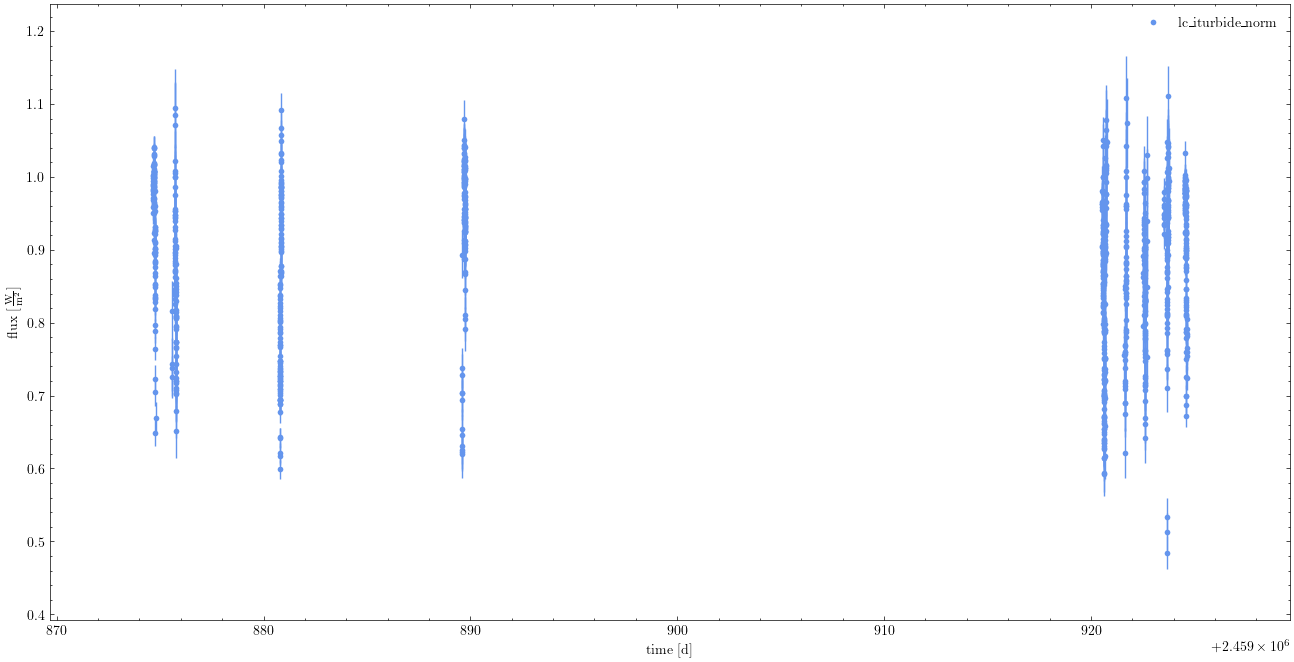

(<autofig.figure.Figure | 1 axes | 1 call(s)>,
 <Figure size 1600x800 with 1 Axes>)

In [66]:
b.add_dataset('lc', dataset='lc_iturbide_norm', overwrite=True,
              times=iturbideObservations['bjd'].to_numpy(), 
              fluxes=iturbideObservations['norm_flux'].to_numpy(), 
			  sigmas=iturbideObservations['norm_ferr'].to_numpy())

fig = plt.figure(figsize=(16,8))
b.plot(dataset='lc_iturbide_norm', show=True, marker='.', c=gen_utils.ITURBIDE_PLOT_COLORS, s=0.008, legend=True, fig=fig)

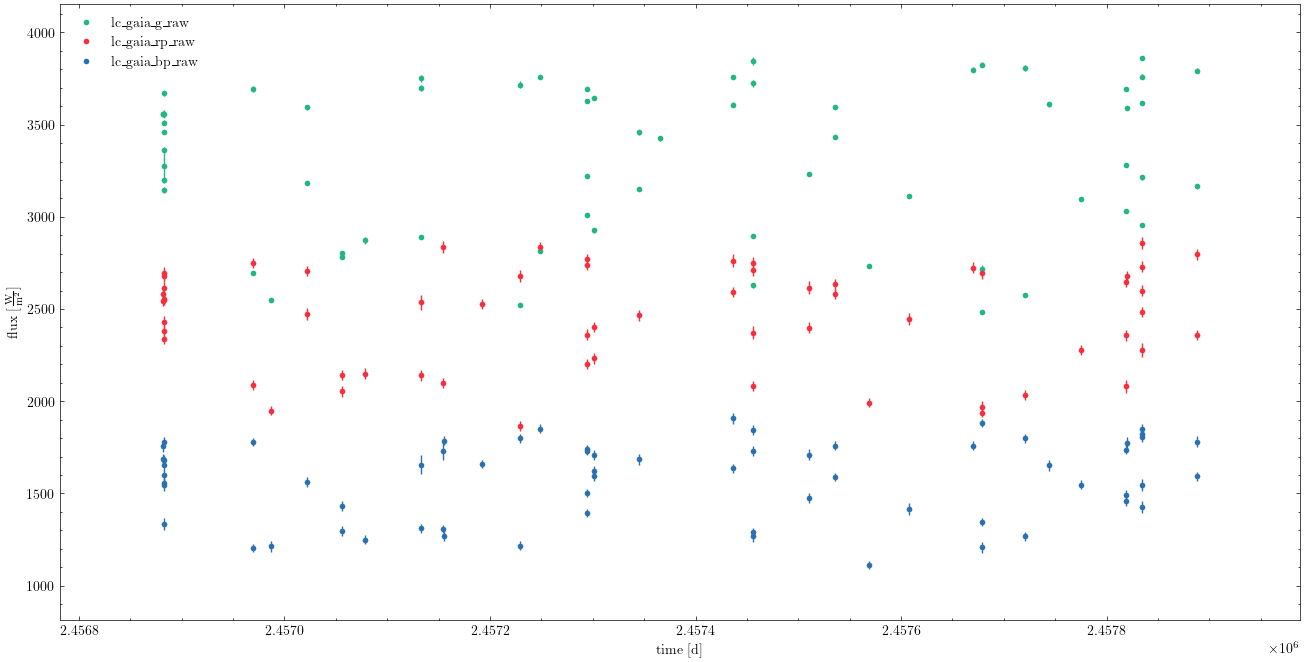

(<autofig.figure.Figure | 1 axes | 3 call(s)>,
 <Figure size 1600x800 with 1 Axes>)

In [67]:
# TODO: if absolute fluxes are desirable, try to determine conversion from Gaia el/s to W/m^2
# ignoring units for now as work-around
b.add_dataset('lc', 
              times=gaia_g['jd'], fluxes=gaia_g['flux'].value, sigmas=gaia_g['flux_error'].value,
              passband='Gaia:G', dataset='lc_gaia_g_raw', overwrite=True)
b.add_dataset('lc', 
              times=gaia_rp['jd'], fluxes=gaia_rp['flux'].value, sigmas=gaia_rp['flux_error'].value,
              passband='Gaia:RP', dataset='lc_gaia_rp_raw', overwrite=True)
b.add_dataset('lc', 
              times=gaia_bp['jd'], fluxes=gaia_bp['flux'].value, sigmas=gaia_bp['flux_error'].value,
              passband='Gaia:BP', dataset='lc_gaia_bp_raw', overwrite=True)

fig = plt.figure(figsize=(16, 8))
b.plot(kind='lc', dataset=['lc_gaia_g_raw', 'lc_gaia_bp_raw', 'lc_gaia_rp_raw'], show=True, legend=True, marker='.', s=0.008, color=gen_utils.GAIA_PLOT_COLORS, fig=fig)

## ZTF Data

Data retrieved using IRSA tools. Observations in `zg` and `zr` bands.

In [68]:
ztfPalomarLocation = EarthLocation.of_site("Palomar")
ztfPalomarLocation

<EarthLocation (-2410346.78217658, -4758666.82504051, 3487942.97502457) m>

utc
utc


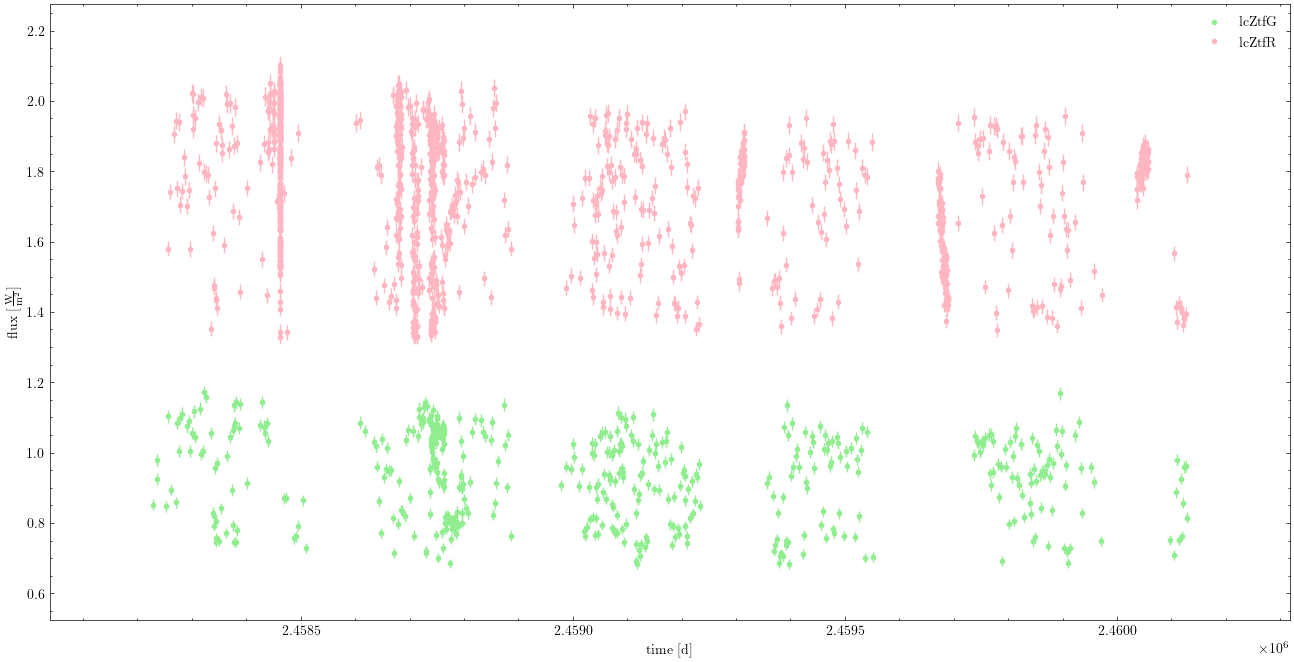

(<autofig.figure.Figure | 1 axes | 2 call(s)>,
 <Figure size 1600x800 with 1 Axes>)

In [69]:
# for nameSuffix, passband, f in zip(["G", "R"], ["ZTF:g", "ZTF:r"], ["zg-flux.ecsv", "zr-flux.ecsv"]):
for nameSuffix, passband, f in zip(["G", "R"], ["ZTF:g", "ZTF:r"], ["rel-zg-flux.ecsv", "rel-zr-flux.ecsv"]):
	data = Table.read(os.path.join(ZTF_DATA_DIR, f))

	# removing bad out of range observations
	dataStd = np.std(data['flux'])
	dataMean = np.mean(data['flux'])
	dataMeanDistance = np.abs(data['flux'] - dataMean)
	removeDataIndices = np.where(dataMeanDistance > 2*dataStd)
	dataMask = np.zeros(len(data), dtype=bool)
	dataMask[removeDataIndices] = 1
	dataMask = ~dataMask
	data = data[dataMask]

	ztfHjdTime = Time(data['hjd'], scale='utc', format='jd')
	heliocentricCorrection = ztfHjdTime.light_travel_time(skycoord=objCoord, kind='heliocentric', location=ztfPalomarLocation)
	barycentricCorrection = ztfHjdTime.light_travel_time(skycoord=objCoord, kind='barycentric', location=ztfPalomarLocation)

	# ztfBjdTime = (ztfHjdTime - heliocentricCorrection) + barycentricCorrection
	ztfBjdTime = ztfHjdTime + barycentricCorrection
	print(ztfBjdTime.scale)
	b.add_dataset('lc', 
			   times=ztfBjdTime.tcb.jd, fluxes=data['flux'], sigmas=data['fluxerr'],
			   passband=passband, dataset=f'lcZtf{nameSuffix}', overwrite=True)
	
fig = plt.figure(figsize=(16, 8))
b.plot(dataset=['lcZtfG', 'lcZtfR'], marker='.', legend=True, color=gen_utils.ZTF_PLOT_COLORS, s=0.008, show=True, fig=fig)

## Orbital Period

Setting orbital period to that determined using Lomb-Scargle Multiband periodogram in `period-analysis/periodogram.ipynb`

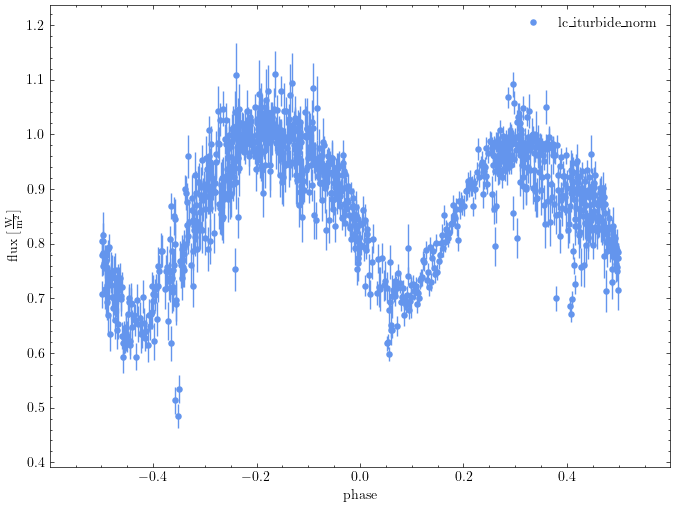

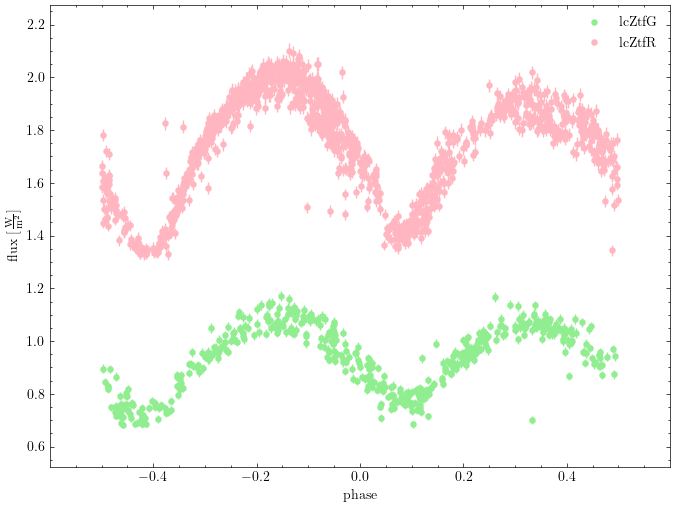

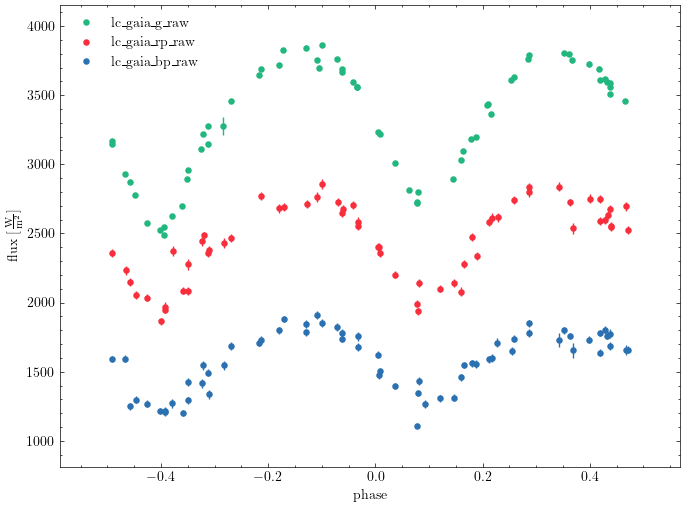

(<autofig.figure.Figure | 1 axes | 3 call(s)>,
 <Figure size 800x600 with 1 Axes>)

In [71]:
LS_MULTIBAND_PERIOD = 0.3335660396161509 * u.day
b.set_value(qualifier='period', component='binary', value=LS_MULTIBAND_PERIOD)

# Iturbide
b.plot(x='phase', dataset='lc_iturbide_norm', marker='.', legend=True, s=0.015, color=gen_utils.ITURBIDE_PLOT_COLORS, show=True)

# ZTF
b.plot(x='phase', dataset=['lcZtfG', 'lcZtfR'], marker='.', legend=True, color=gen_utils.ZTF_PLOT_COLORS, s=0.015, show=True)

# Gaia
rawGaiaDatasets = [d for d in b.datasets if 'gaia' in d and 'raw' in d]
b.plot(x='phase', dataset=rawGaiaDatasets, marker='.', legend=True, color=gen_utils.GAIA_RAW_PLOT_COLORS, s=0.015, show=True)

## Poro et al. (2021) Priors

In [19]:
b.flip_constraint(qualifier='mass', component='primary', solve_for="sma@binary")

<ConstraintParameter: {sma@binary@component} = (((({mass@primary@component} * ({period@binary@component} ** 2.000000)) * ({q@binary@component} + 1.000000)) * 2942.206217504419328179210424423218) / 39.478418) ** (1./3) (solar units) => 3.3499999999999996 solRad>

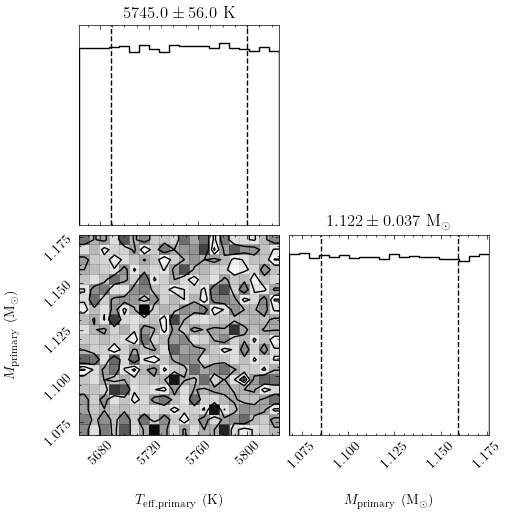

In [20]:
# Poro et al. (2021) [Investigation of P_orb and other params relationships]
# using uninformative uniform priors; mainly looking to restrict optimizer parameter space
p_orb = b.get_value(qualifier='period', component='binary')

# primary T_eff
upperTeffPrimary = (6951.42 + 112.16)*p_orb + (3426.01 + 44.12)
lowerTeffPrimary = (6951.42 - 112.68)*p_orb + (3426.01 - 43.90)

# primary mass
upperMassPrimary = (2.924 + 0.075)*p_orb + (0.147 + 0.029)
lowerMassPrimary = (2.924 - 0.075)*p_orb + (0.147 - 0.029)

b.add_distribution({
	'teff@primary': phoebe.uniform(high=upperTeffPrimary, low=lowerTeffPrimary, unit=u.K),
	'mass@primary': phoebe.uniform(high=upperMassPrimary, low=lowerMassPrimary, unit=u.solMass)
}, distribution='poro_porb_bounds', overwrite_all=True)

_ = b.plot_distribution_collection(distribution='poro_porb_bounds', show=True)

## Save bundle

In [21]:
gen_utils.saveBundle(b, bundleName="contact-model")

Sat, 20 Jul 2024 23:59 PARAMETERS   WARNING for faster compact saving, install ujson


'bundle-saves/contact-model.json.gz'